In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_ctrp as util
import os
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras import regularizers

# Specify the data folder
data_folder = os.path.join('..', 'data')
# Loading data
data = util.load_communities_data(data_folder)

# Data preprocessing
attributes, target = data.columns[3:-1], data.columns[-1]
attributes_nr = [a for a in attributes if a != 'race']
nf = [a for a in attributes if a != 'race'] + [target]

# Standardization and train/test split
tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
tmp = data.iloc[:tr_sep]

sdata = data.copy()
sdata[nf] = (sdata[nf] - tmp[nf].mean()) / (tmp[nf].std())

sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]

2024-01-25 13:57:01.802553: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 13:57:01.834715: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 13:57:01.834745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 13:57:01.834767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 13:57:01.840243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 13:57:01.840848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Mitigating Discrimination<br> in Machine Learning

### Introducing the Problem

## Fairness Issues in Machine Learning

**Say we want to estimate the risk of violent crimes in given population**

<center><img src="assets/minority-report.jpg" width=23%/></center>

* This is obviously a very _ethically sensitive task_
* ...Which makes it a good test case to discuss _fairness in data-driven methods_


## Fairness in Data-Driven Methods

**Fairness in data-driven methods is _very actual topic_**

* As data-driven systems become more pervasive
* They have the potential to significantly affect social groups

**Once you deploy an AI model, _performance is not enough_**

* You might have stellar accuracy and efficient inference
* ...And still end up causing all sort of havoc

**This is so critical that the topic is _starting to be regulated_**

* The EU has drafted [Ethics Guidelines for Trustworthy AI](https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai)
* ...And has reached provisional agreement on a big [AI act](https://www.europarl.europa.eu/news/en/headlines/society/20230601STO93804/eu-ai-act-first-regulation-on-artificial-intelligence)
* In some application fields, models that do not comply with some rules cannot be deployed

## Inspecting the Dataset

**We will run an experiment on a version of the ["crime" UCI dataset](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)**

In [2]:
display(data.head())
print(f'Number of rows: {len(data)}')

,communityname,state,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
1008,EastLampetertownship,PA,5,11999,0,0.1203,0.2544,0.1208,0.1302,0.5776,...,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000,147.49
1271,EastProvidencecity,RI,6,50380,0,0.1171,0.2459,0.1159,0.1660,1.0000,...,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000,150.88
1936,Betheltown,CT,9,17541,0,0.1356,0.2507,0.1138,0.0804,0.8514,...,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000,95.47
1601,Crowleycity,LA,8,13983,0,0.1506,0.2587,0.1234,0.1302,0.0000,...,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000,1029.02
293,Pawtucketcity,RI,2,72644,0,0.1230,0.2725,0.1276,0.1464,1.0000,...,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103,458.28


Number of rows: 1993


* The target is "violentPerPop" (number of violent offenders per 100K people)
* All attributes are continuous, except for "race"

## A First Attempt at Mitigating Discrmination

**The "race" attribute seems like one that could easily lead to discrimination**

...So we'll attempt to _keep it out_

In [3]:
data[attributes_nr].head()

,pop,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,...,persHomeless,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit
1008,11999,0.1203,0.2544,0.1208,0.1302,0.5776,34720,0.8275,0.0376,0.5482,...,0.000000,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000
1271,50380,0.1171,0.2459,0.1159,0.1660,1.0000,31007,0.7400,0.0059,0.4359,...,0.000000,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000
1936,17541,0.1356,0.2507,0.1138,0.0804,0.8514,53761,0.8562,0.0050,0.5863,...,0.000000,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000
1601,13983,0.1506,0.2587,0.1234,0.1302,0.0000,13804,0.6245,0.0242,0.2248,...,0.000000,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000
293,72644,0.1230,0.2725,0.1276,0.1464,1.0000,26541,0.7526,0.0038,0.3694,...,1.376576,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103


* This is one of the first solutions that typically come to mind to mitigate unwanted bias
* We've also removed some columns that are not useful as model inputs/outputs

## Baseline

**Let's establish a baseline by tackling the task via Linear Regression**

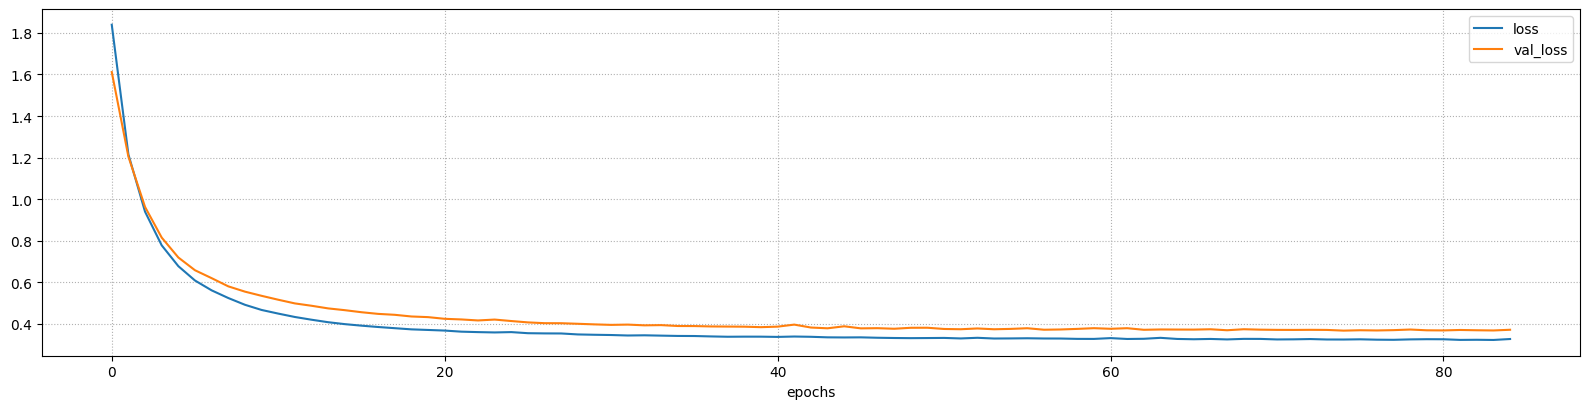

Final loss: 0.3277 (training), 0.3723 (validation)


In [4]:
nn = util.build_nn_model(input_shape=len(attributes_nr), output_shape=1, hidden=[], output_activation='linear')
history = util.train_nn_model(nn, tr[attributes_nr], tr[target], loss='mse', batch_size=32, epochs=400, verbose=0, validation_split=0.2)
util.plot_training_history(history, figsize=figsize)

## Baseline Evaluation

**...And let's check the results**

In [5]:
tr_pred = nn.predict(tr[attributes_nr], verbose=0)
r2_tr, mae_tr = r2_score(tr[target], tr_pred), mean_absolute_error(tr[target], tr_pred)
ts_pred = nn.predict(ts[attributes_nr], verbose=0)
r2_ts, mae_ts = r2_score(ts[target], ts_pred), mean_absolute_error(ts[target], ts_pred)
print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')
print(f'MAE: {mae_tr:.2f} (training), {mae_ts:.2f} (test)')

R2 score: 0.67 (training), 0.61 (test)
MAE: 0.39 (training), 0.45 (test)


* Some improvements (not much) can be obtained with a Deeper model

> Without the "race" attribute, we might think that no discrminiation can occur<br>**....But is it true?**

## Disparate Treatment

**Indeed, our model _treats the groups differently_**

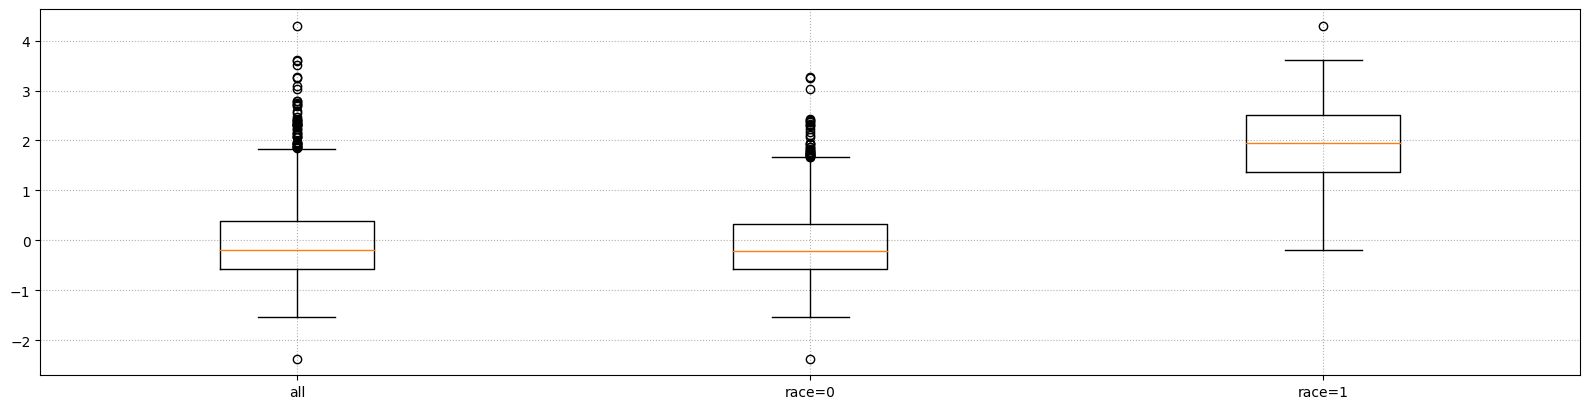

In [6]:
protected={'race': (0, 1)}
util.plot_pred_by_protected(tr, tr_pred, protected={'race': (0, 1)}, figsize=figsize)

* Here we inspecte the distribution of predictions for the "race = 0" and "race =1" groups
* ...And the two are indeed significantly different

# Mitigating Discrimination<br> in Machine Learning

### Fairness Metrics

## Fairness Metrics

**Evaluating fairness is complicated**

* Ethical topics are almost always quite nuanced
* ...And they do not lend themselves to clear, unambiguous definitions

**From an algorithmic purpose, however...**

...One of the most manageable approach consists in relying on a _fairness metric_

* Even if any discrimination metric may indeed be questionable
* ...Measurable quantities can at least be manipulated with Maths

**[Several fairness metrics](https://dl.acm.org/doi/abs/10.1145/3457607?casa_token=7K5cttUU8CMAAAAA:eOTbdtdJRlHvrexenK9WGomYr4EZJ4I5xEUAQiyxmNAwVzAcnfDnjzBXt_D2aU4vfLRNM7VPC-g) have been proposed**

* Since defining a single, catch-all, metric seems unrealistic
* Having the ability to choose among multiple options is a good thing

Here we will focus on the idea of _disparate treatment_

## The DIDI Indicator

**In particular, we will use the indicatror from [this paper](https://www.aaai.org/ojs/index.php/AAAI/article/download/3943/3821)**

* Given a set of categorical _protected attribute (indexes) $J_p$_
* ...The Disparate Impact Discrimination Index (for regression) is given by:

$$
\text{DIDI}_r = \sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* Where $D_j$ is the domain of attribute $j$
* ...And $I_{j,v}$ is the set of example such that attribute $j$ has value $v$




**The DIDI is a measure of discrepancy w.r.t. the average prediction**

* It is obtained by computing the average prediction for every protected group
* ...And summing up their discrepancy w.r.t. the global average

## Using the DIDI to Evaluate Our Model

**For our Linear Regression model, we get**

In [7]:
tr_DIDI = util.DIDI_r(tr, tr_pred, protected)
ts_DIDI = util.DIDI_r(ts, ts_pred, protected)
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

DIDI: 2.03 (training), 2.16 (test)


* We wish to _improve over this baseline_, which is not an easy task:
* Discrimination is a form of bias in the training set, but bias is not necessarily bad

**In fact, ML works _because of bias_**

...I.e. because the training distribution contains information about the test one

* Improving fairness requires to _get rid of the unwanted part_ of this bias
* ...Which will likely lead to some _loss of accuracy_ (hopefully not too much)

# Mitigating Discrimination<br> in Machine Learning

### Fairness Constraints

## Fairness as a Constraint

**Let's recap our goals:**

We want to train an accurate regressor ($L = $ loss function):

$$
\operatorname{argmin}_{\theta} \mathbb{E}_{x, y \sim P(X, Y)}\left[ L(y, \hat{f}(x, \theta)) \right]
$$

We want to measure fairness via the DIDI:

$$
\operatorname{DIDI}(y) = \sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

...And we want the DIDI to be low, e.g.:

$$
\operatorname{DIDI}(\hat{f}(x, \theta)) \leq \varepsilon
$$

## Fairness as a Constraint

**We can use this information to re-state the training problem**

$$
\operatorname{argmin}_{\theta} \left\{ \mathbb{E}_{x, y}\left[ L(y, \hat{f}(x, \theta)) \right] \mid \operatorname{DIDI}(\hat{f}(x, \theta)) \leq \varepsilon \right\}
$$

* Training is now a _constrained optimization_ problem
* We require the DIDI _for ML output_ to be within acceptable levels

After training, the constraint will be _distilled_ in the model parameters

**We are requiring constraint satisfaction _on the training set_**

...Meaning that we'll have _no satisfaction guarantee on unseen examples_

* This is suboptimal, but doing better is very difficult
* ...Since our constraint is defined (conceptually) _on the whole distribution_

We'll trust the model to generalize well enough

## Constrained Machine Learning

**There's more than one way to account for constraints while training**

* The one we'll focus on is based on the idea to add a _constrained based penalty_
* In particular, we will modify our training problem as follows:

$$
\operatorname{argmin}_{\theta} \mathbb{E}_{x, y}\left[ L(y, \hat{f}(x, \theta))\right] +\lambda \max\left(0, \operatorname{DIDI}(\hat{f}(x, \theta)) - \varepsilon \right)
$$

**Without going into too much detail, the term $\max\left(0, \operatorname{DIDI}(\hat{f}(x, \theta)) - \varepsilon \right)$:**

* Is equal to 0 if the constraint $\operatorname{DIDI}(\hat{f}(x, \theta)) \leq \varepsilon$ is satisfied
* Is $> 0$ otherwise, meaning it acts as a _penalty_ in this case
* The penalty is scaled by a factor $\lambda$
* ...which can be increased until the constraint is satisfied

There are a lot of caveats, but will skip them

## Building the Constrained Model

**We can build a constrained version of our predictor**

In [8]:
protected = {'race': (0, 1)}
didi_thr = 1.0
base_pred = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[])
nn = util.LagDualDIDIModel(base_pred, attributes, protected, thr=didi_thr)

**We will try to roughly halve the "natural" DIDI of the model**

* Since for our baseline we have $\operatorname{DIDI}(y) \simeq 2$
* ...We decided to pick $\varepsilon = 1$

**Even if we are focusing here on a DIDI constraint**

* The approach can be employed for _other fairness metrics_
* ...And also for constraints not related to fairness (e.g. domain knowledge)

## Training the Constrained Model

**We can train the constrained model more or less as usual**

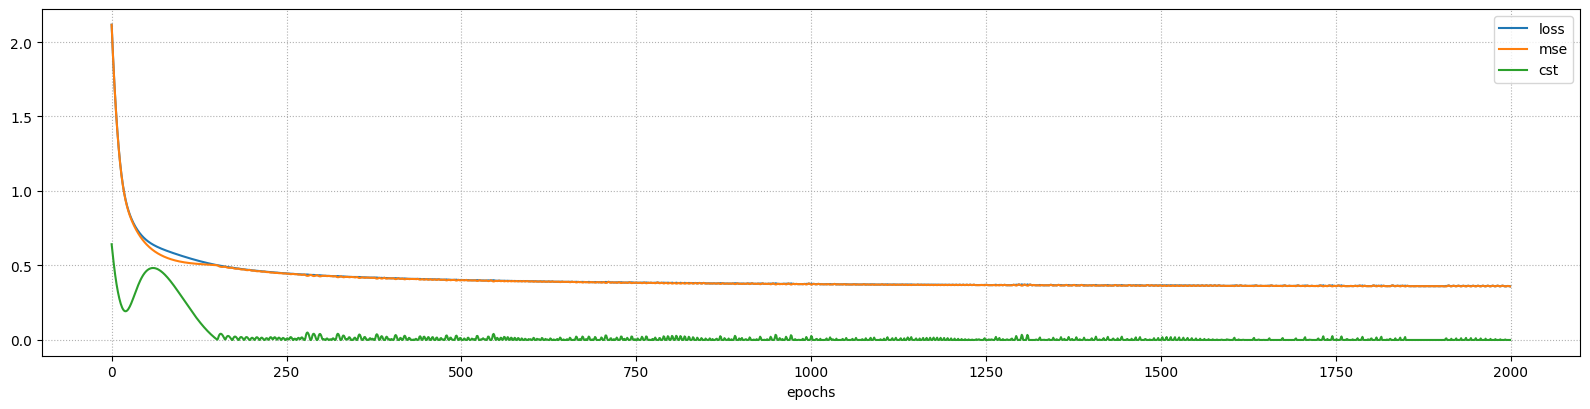

Final loss: 0.3598 (training)


In [9]:
base_pred = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[])
nn = util.LagDualDIDIModel(base_pred, attributes, protected, thr=didi_thr)
history = util.train_nn_model(nn, tr[attributes], tr[target], loss='mse', validation_split=0., epochs=2000, batch_size=len(tr))
util.plot_training_history(history, figsize=figsize)

## Constrained Model Evaluation

**Let's check both the prediction quality and the DIDI**

In [10]:
tr_pred = nn.predict(tr[attributes], verbose=0)
r2_tr = r2_score(tr[target], tr_pred)
ts_pred = nn.predict(ts[attributes], verbose=0)
r2_ts = r2_score(ts[target], ts_pred)
tr_DIDI = util.DIDI_r(tr, tr_pred, protected)
ts_DIDI = util.DIDI_r(ts, ts_pred, protected)

print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

R2 score: 0.64 (training), 0.56 (test)
DIDI: 0.99 (training), 1.09 (test)


**We lost some accuracy, but the DIDI has the desired value on the training data**

* On the test data, the value is a bit larger than we wished
* This happened since we enforced the constraint _only on the training data_

## Some Comments

**This is not the only approach for constrained ML**

* There approaches based on projection, pre-processing, iterative projection...
* ...And in some cases you can enforce constraints through the architecture itself

**...But it is simple and flexible**

* You just need your constraint to be differentiable
* ...And some good will to tweak the implementation

**The approach can be used also for _symbolic knowledge injection_**

* Perhaps domain experts can provide you some intuitive rule of thumbs
* You model those as constraints and take them into account at training time
* Just be careful with the weights, as in this case feasibility is not the goal